## Goal

Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.
The data revolution has a lot to do with the fact that now we are able to collect all sorts of data
about people who buy something on our site as well as people who don't. This gives us a
tremendous opportunity to understand what's working well (and potentially scale it even further)
and what's not working well (and fix it).
The goal of this challenge is to build a model that predicts conversion rate and, based on the
model, come up with ideas to improve re]enue.
This challenge is significantly easier than all others in this collection. There are no dates, no
tables to join, no feature engineering required, and the problem is really straightforward.
Therefore, it is a great starting point to get familiar with data science takehome challenges.
You should not move to the other challenges until you fully understand this one.

## Challenge Description
We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).
Your project is to:

1. Predict conversion rate /
2. Come up with recommendations for the product team and the marketing team to improve conversion rate

In [127]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.simplefilter("ignore")

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

### 1. Load the data

In [56]:
conv_df = pd.read_csv("DS Take Home 1-3/1.conversion/conversion_data.csv")

In [57]:
conv_df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [48]:
conv_df.shape

(316200, 6)

In [9]:
conv_df.describe()
#find outlier in max age

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


<Axes: >

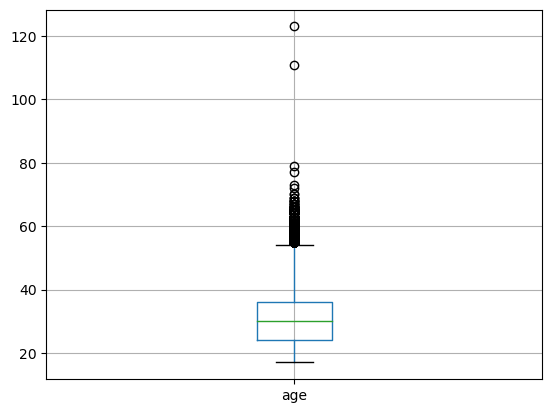

In [50]:
# Check outlier
conv_df.boxplot("age")

In [ ]:
conv_df[conv_df['age'] > 100]

In [52]:
# 2 rows of outliers that we can just remove
conv_df[conv_df["age"]>100].shape

(2, 6)

In [58]:
## deal with outliers
#q = conv_df["age"].quantile(0.99)
#q
conv_df = conv_df[conv_df["age"]<=100] 


In [60]:
#conv_df[conv_df["age"]>100].shape

(0, 6)

In [59]:
conv_df.shape

(316198, 6)

In [61]:
conv_df.info()

## no missing data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316198 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316198 non-null  object
 1   age                  316198 non-null  int64 
 2   new_user             316198 non-null  int64 
 3   source               316198 non-null  object
 4   total_pages_visited  316198 non-null  int64 
 5   converted            316198 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 16.9+ MB


In [62]:
# show all unique values
for column in conv_df.columns:
    print(conv_df[column].unique()[:5])

['UK' 'US' 'China' 'Germany']
[25 23 28 39 30]
[1 0]
['Ads' 'Seo' 'Direct']
[1 5 4 6 2]
[0 1]


In [63]:
# check target varible which is highly unbalanced
conv_df.groupby("converted").count()

,country,age,new_user,source,total_pages_visited
converted,,,,,
0,306000,306000,306000,306000,306000
1,10198,10198,10198,10198,10198


### 2. Data Exploration

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# country
conv_df["country"].value_counts()

US         178092
China       76602
UK          48449
Germany     13055
Name: country, dtype: int64

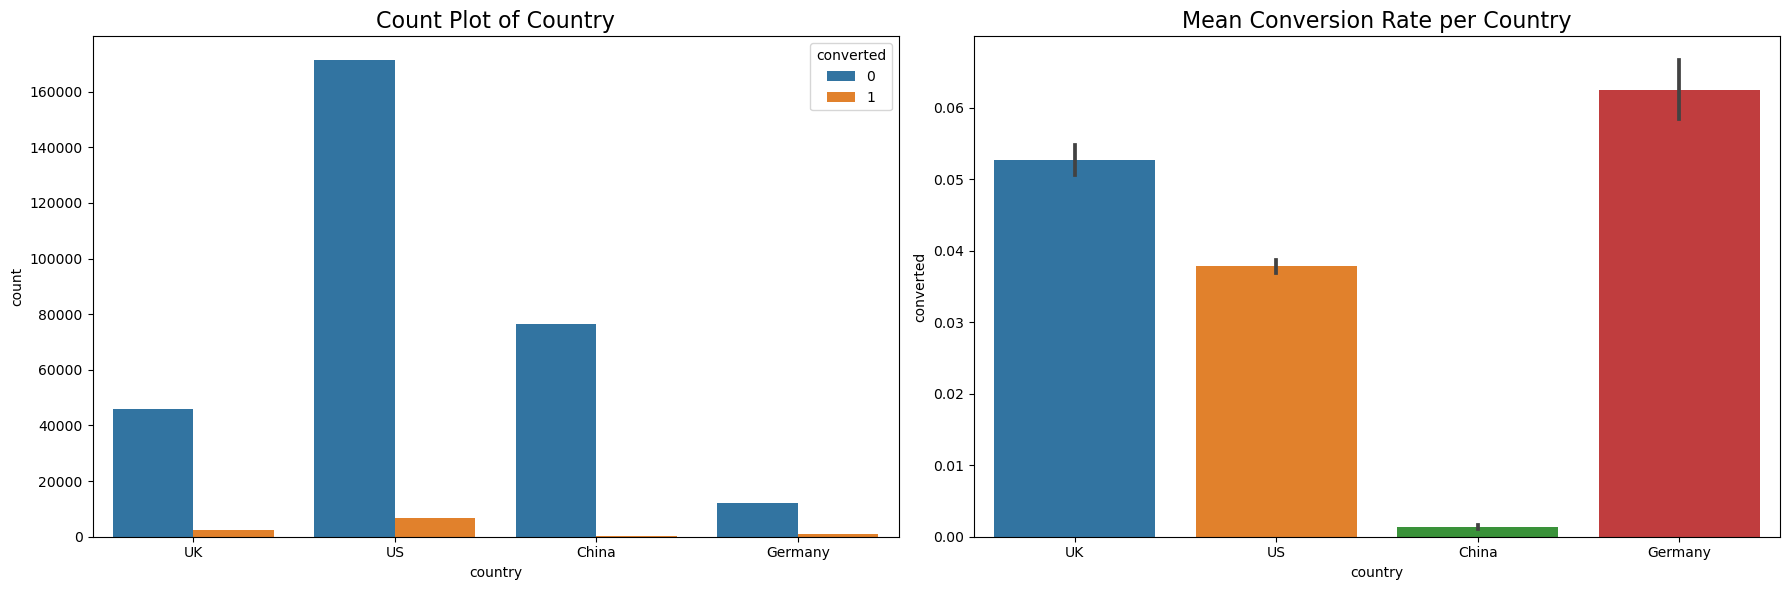

In [84]:
# Visualizations of different countries
#grouped = conv_df[["country","converted"]].groupby("country").mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
# draw countplot in the first row
sns.countplot(x = 'country', hue = "converted", data = conv_df, ax = ax[0])
ax[0].set_title('Count Plot of Country', fontsize = 16)
#ax[0].set_yscale('log')
# draw barplot in the second row
sns.barplot(x = 'country', y = "converted", data = conv_df, ax = ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize = 16)

plt.tight_layout()
plt.show()




<Axes: xlabel='age', ylabel='total_pages_visited'>

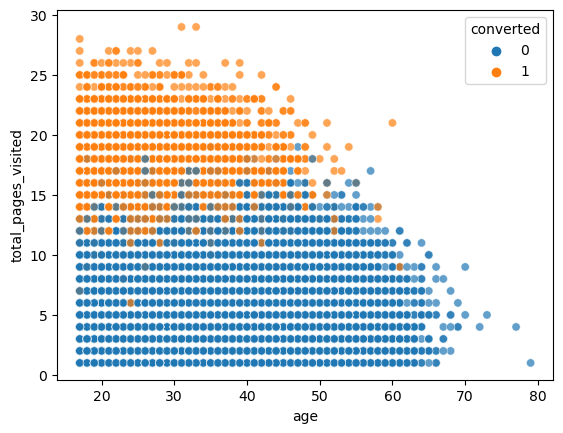

In [66]:
# age & page_visits
sns.scatterplot(data=conv_df, x='age',hue='converted', y='total_pages_visited', 
                alpha=0.7 )

In [67]:
# new users
conv_df.groupby("new_user").count()

,country,age,source,total_pages_visited,converted
new_user,,,,,
0,99454,99454,99454,99454,99454
1,216744,216744,216744,216744,216744


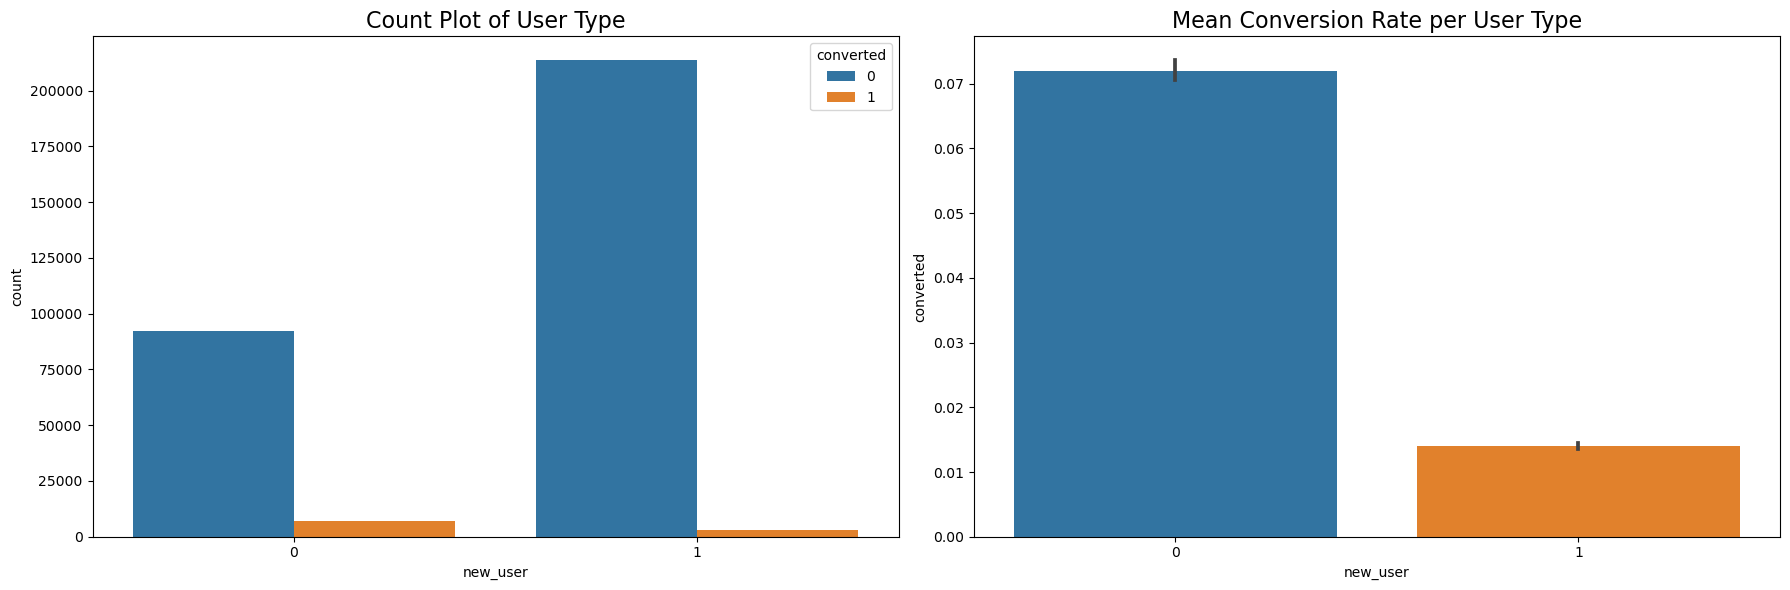

In [86]:
# Visualizations of different user_types
#grouped = conv_df[["country","converted"]].groupby("country").mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
# draw countplot in the first row
sns.countplot(x = 'new_user', hue = "converted", data = conv_df, ax = ax[0])
ax[0].set_title('Count Plot of User Type', fontsize = 16)
#ax[0].set_yscale('log')
# draw barplot in the second row
sns.barplot(x = 'new_user', y = "converted", data = conv_df, ax = ax[1])
ax[1].set_title('Mean Conversion Rate per User Type', fontsize = 16)

plt.tight_layout()
plt.show()

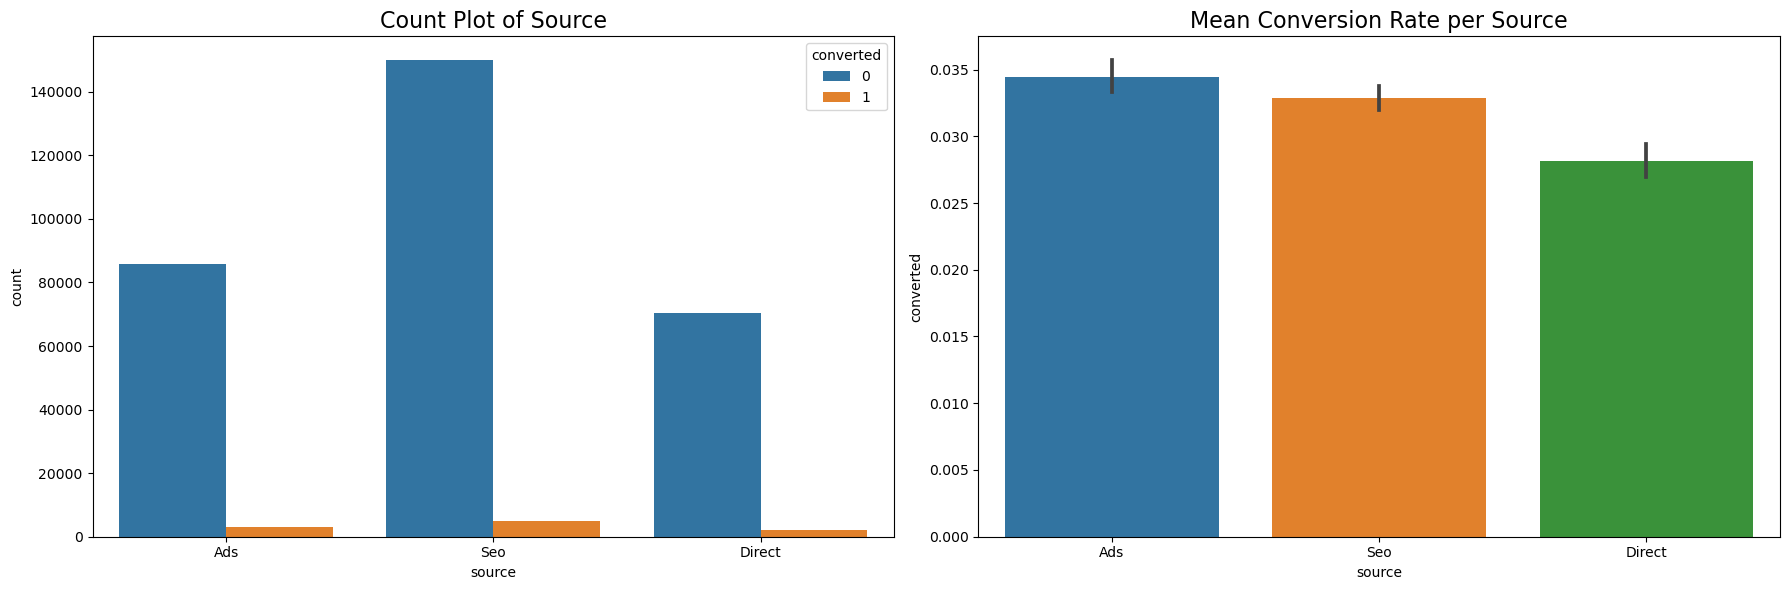

In [87]:
# Visualizations of different source
#grouped = conv_df[["country","converted"]].groupby("country").mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
# draw countplot in the first row
sns.countplot(x = 'source', hue = "converted", data = conv_df, ax = ax[0])
ax[0].set_title('Count Plot of Source', fontsize = 16)
#ax[0].set_yscale('log')
# draw barplot in the second row
sns.barplot(x = 'source', y = "converted", data = conv_df, ax = ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize = 16)

plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='Count'>

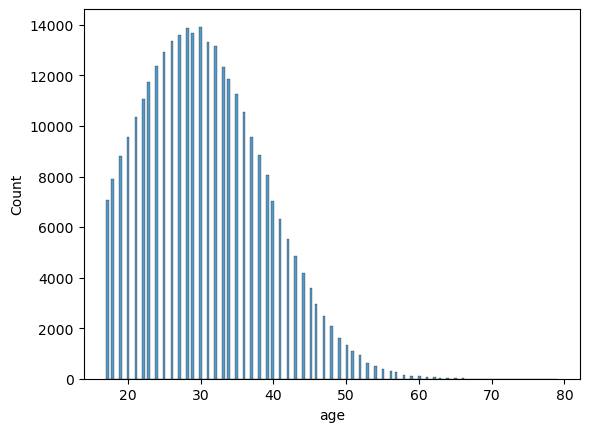

In [100]:
sns.histplot(conv_df[conv_df['converted'] == 0]['age'], label='Converted 0')

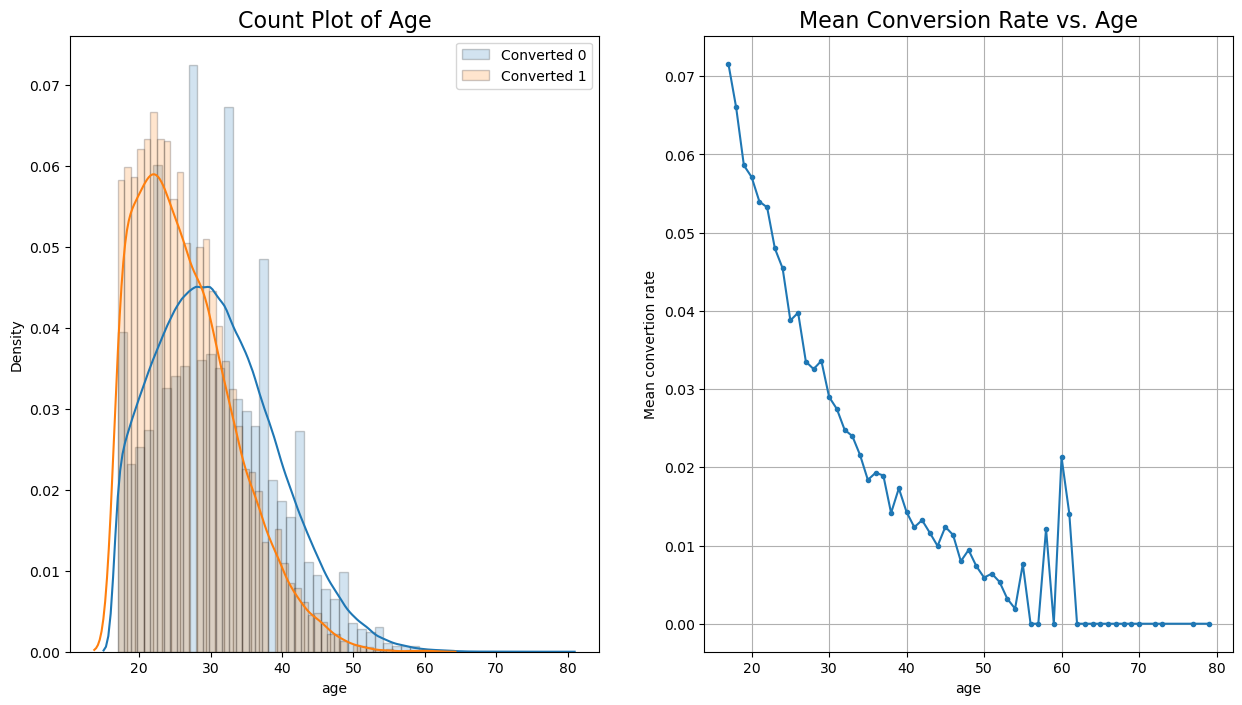

In [119]:
# Visualization of different age
grouped = conv_df[["age","converted"]].groupby("age").mean().reset_index()
hist_kws ={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,8))

sns.distplot(conv_df[conv_df['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(conv_df[conv_df['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)

ax[0].set_title("Count Plot of Age",fontsize = 16)
ax[0].legend()

ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

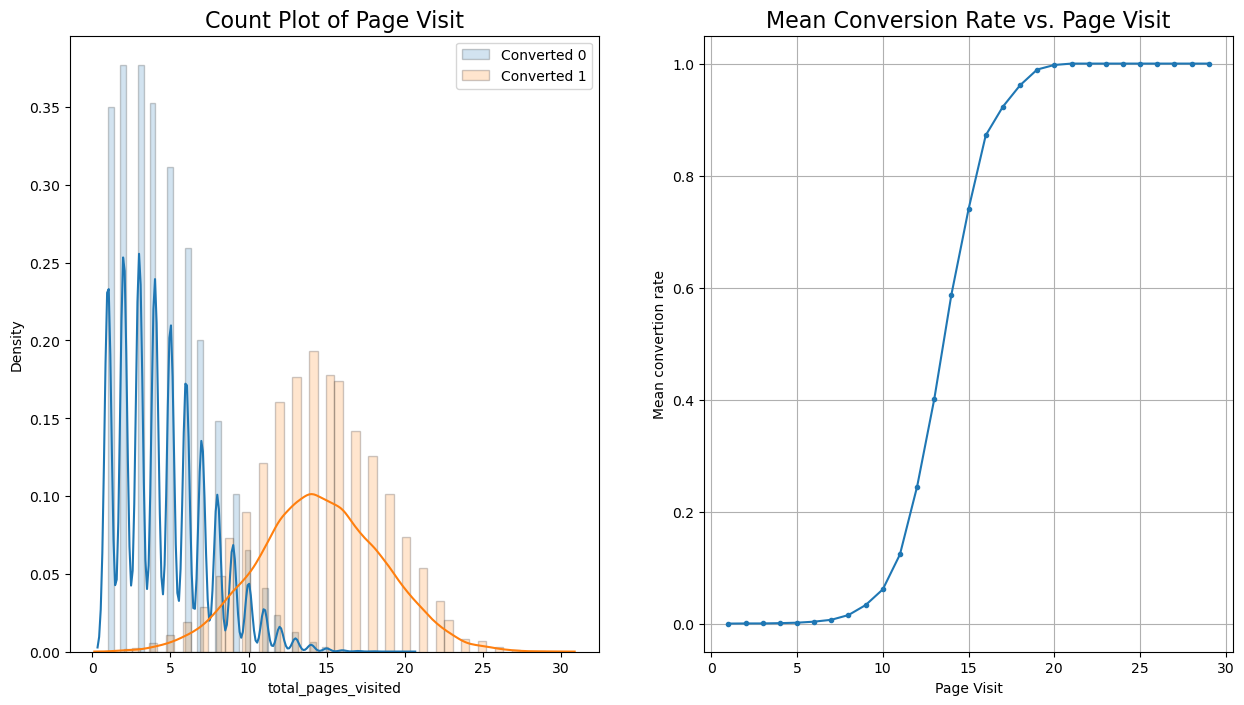

In [121]:
# Visualization of different visits
grouped = conv_df[["total_pages_visited","converted"]].groupby("total_pages_visited").mean().reset_index()
hist_kws ={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,8))

sns.distplot(conv_df[conv_df['converted'] == 0]['total_pages_visited'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(conv_df[conv_df['converted'] == 1]['total_pages_visited'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)

ax[0].set_title("Count Plot of Page Visit",fontsize = 16)
ax[0].legend()

ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Page Visit', fontsize=16)
ax[1].set_xlabel('Page Visit')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

In [68]:
## all variables
# sns.pairplot(conv_df) # not really helpful here

/var/folders/5t/045mbq7j45s5wx1xr8rw_ml80000gq/T/ipykernel_61335/2066234662.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = conv_df.corr()


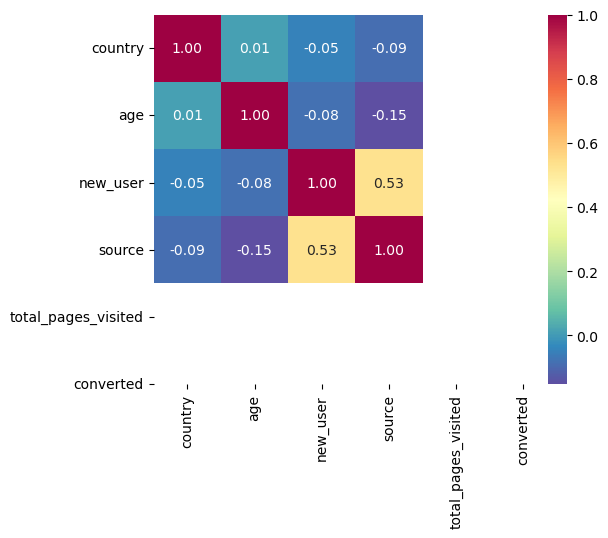

In [69]:

corrmat = conv_df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=conv_df.columns, 
                 xticklabels=conv_df.columns, 
                 cmap="Spectral_r")
plt.show()

## 3. Model Building

H2O is a fully open-source, distributed in-memory machine learning platform with linear scalability. H2O supports the most widely used statistical & machine learning algorithms, including gradient boosted machines, generalized linear models, deep learning, and many more.

H2O also has an industry-leading AutoML functionality (available in H2O ≥3.14) that automates the process of building a large number of models, to find the “best” model without any prior knowledge or effort by the Data Scientist. H2O AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit.

H2O’s AutoML can also be a helpful tool for the novice as well as advanced users. It provides a simple wrapper function that performs a large number of modeling-related tasks that would typically require many lines of code. 

### This essentially frees up the time to focus on other aspects of the data science pipeline, such as data preprocessing, feature engineering, and model deployment.



In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 3.1 Preparation

In [166]:
X = conv_df.drop("converted", 1
                )
y = conv_df['converted']

In [147]:
# One Hot Encoding catagorical Variables
#catagorical features

cat_cols = [col for col in conv_df.select_dtypes(exclude = np.number).columns]
cat_cols
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                one_hot,
                                cat_cols)],
                                remainder = "passthrough")
transformer_x = transformer.fit_transform(X)
transformer_x
pd.DataFrame(transformer_x)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,25.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,23.0,1.0,5.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,28.0,1.0,4.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,1.0,5.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...
316193,0.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,1.0,9.0
316194,0.0,0.0,0.0,1.0,0.0,1.0,0.0,27.0,1.0,6.0
316195,1.0,0.0,0.0,0.0,1.0,0.0,0.0,25.0,0.0,4.0
316196,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22.0,0.0,4.0


In [167]:
dummies =pd.get_dummies(conv_df[cat_cols])
dummies


,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,0,0,1,0,1,0,0
1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1
3,1,0,0,0,0,0,1
4,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...
316195,0,0,0,1,1,0,0
316196,0,0,0,1,0,1,0
316197,1,0,0,0,1,0,0
316198,0,0,0,1,0,0,1


In [168]:
X = pd.merge(X,dummies, left_index=True, right_index=True)

In [169]:
X = X.drop(["country","source"],axis =1)

In [170]:
X

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,1,1,0,0
316196,27,1,6,0,0,0,1,0,1,0
316197,25,0,4,1,0,0,0,1,0,0
316198,22,0,4,0,0,0,1,0,0,1


### Split data

In [175]:
np.random.seed(42)
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size = 0.2)

In [176]:
print(X_train.shape)
print(y_train.shape)

(252958, 10)
(252958,)


### 3.2 Model Comparison

Logistic Regression: basic linear classifier (good to baseline) \
Random Forest: ensemble bagging classifier \
K-Nearest Neighbors: instance based classifier \
Support Vector Machines: maximum margin classifier \
Gaussian Naive Bayes: probabilistic classifier \
XGBoost: ensemble (extreme!) boosting classifier


In [185]:
#Logistical Regression

from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model_lr = LogisticRegression(solver='lbfgs',max_iter=1000)

model_lr.fit(X_train,y_train)
model_lr.score(X_test, y_test)

0.9865749525616698

In [190]:
print(classification_report(y_test, model_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.86      0.69      0.77      2035

    accuracy                           0.99     63240
   macro avg       0.93      0.84      0.88     63240
weighted avg       0.99      0.99      0.99     63240



In [192]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
model_rf.score(X_test, y_test)

0.9851992409867173

In [193]:
print(classification_report(y_test, model_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.83      0.68      0.75      2035

    accuracy                           0.99     63240
   macro avg       0.91      0.84      0.87     63240
weighted avg       0.98      0.99      0.98     63240



In [186]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

model_dr = DecisionTreeClassifier(max_depth=2, random_state=22)
model_dr.fit(X_train, y_train)
#using accuracy as our performance metric
score = model_dr.score(X_test, y_test)
print(score)

0.9820208728652752


In [194]:
print(classification_report(y_test, model_dr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     61205
           1       0.89      0.50      0.64      2035

    accuracy                           0.98     63240
   macro avg       0.94      0.75      0.82     63240
weighted avg       0.98      0.98      0.98     63240



### Draw multiple auc curve in one plot

Text(0.5, 1.0, 'Receiver Operating Characteristic')

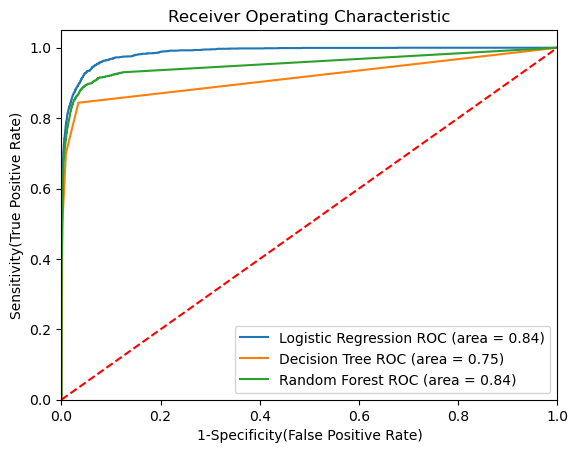

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': model_lr,
},
{
    'label': 'Decision Tree',
    'model': model_dr,
},
{
    'label': 'Random Forest',
    'model': model_rf,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')

### 3.2 Rebuild model with sampled data to deal with unbalance

In [204]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [208]:
# instantiating the random undersampler
rus = RandomUnderSampler() 
# resampling X, y
X_rus, y_rus = rus.fit_resample(X_train, y_train)
# new class distribution
# print(Counter(y_rus))
# Counter({0: 156, 1: 156})

In [210]:
#Logistical Regression as it is the best performing model

from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model_lr_s = LogisticRegression(solver='lbfgs',max_iter=1000)

model_lr_s.fit(X_rus,y_rus)
model_lr_s.score(X_test, y_test)

0.9416508538899431

In [211]:
auc = metrics.roc_auc_score(y_test,model_lr_s.predict(X_test))
auc

0.9404015626383079

In [214]:
print(classification_report(y_test,model_lr_s.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     61205
           1       0.35      0.94      0.51      2035

    accuracy                           0.94     63240
   macro avg       0.67      0.94      0.74     63240
weighted avg       0.98      0.94      0.95     63240



## 3.4 Interpret the Model

In [215]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [216]:
final_model = model_lr_s

In [222]:
print(final_model.coef_, final_model.intercept_)

[[-0.07342955 -1.72574836  0.76545228 -2.67425656  1.1622023   0.91278881
   0.59886913 -0.03168264 -0.05688714  0.08817345]] [-4.39710444]


Feature: 0, Score: -0.07343
Feature: 1, Score: -1.72575
Feature: 2, Score: 0.76545
Feature: 3, Score: -2.67426
Feature: 4, Score: 1.16220
Feature: 5, Score: 0.91279
Feature: 6, Score: 0.59887
Feature: 7, Score: -0.03168
Feature: 8, Score: -0.05689
Feature: 9, Score: 0.08817


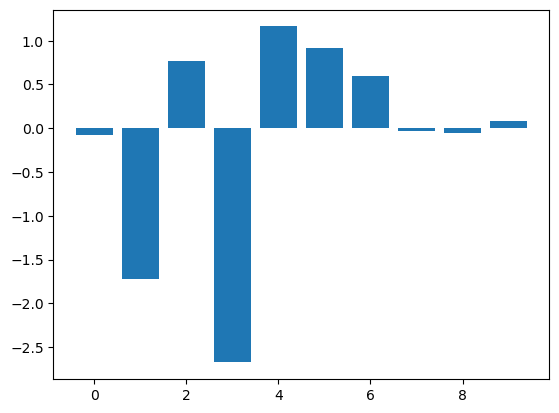

In [218]:
# get importance
importance = final_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [231]:
fea_imp = pd.DataFrame(zip(X_rus.columns, np.transpose(final_model.coef_)), columns=['features', 'coef']) 
fea_imp["coef_abs"] = fea_imp["coef"].abs()
fea_imp.sort_values("coef_abs", ascending = False)
#fea_imp

,features,coef,coef_abs
3,country_China,[-2.6742565574023396],[2.6742565574023396]
1,new_user,[-1.7257483575614787],[1.7257483575614787]
4,country_Germany,[1.162202297430238],[1.162202297430238]
5,country_UK,[0.9127888068194177],[0.9127888068194177]
2,total_pages_visited,[0.7654522821285236],[0.7654522821285236]
6,country_US,[0.5988691274829436],[0.5988691274829436]
9,source_Seo,[0.08817345180129811],[0.08817345180129811]
0,age,[-0.0734295547831691],[0.0734295547831691]
8,source_Direct,[-0.056887140238689196],[0.056887140238689196]
7,source_Ads,[-0.03168263723892891],[0.03168263723892891]
